# Satelliteguard

![Vodnjan Logo](assets/vodnjan-logo.png)

## Detekcija nekretnina i obrađenih površina

Koordinate slike:
Tx = 291083.58, Ty = 4984222.26
Bx = 291564.66, By = 4983991.71

image 1/1 c:\Users\josip\Documents\GitHub\edih-adria\vodnjan-satelliteguard\sample_images\slika_1.png: 320x640 24 houses, 166.0ms
Speed: 1.5ms preprocess, 166.0ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)
Koordinate objekta #1: (291348.87, 4984093.03)
Koordinate objekta #2: (291382.67, 4984003.70)
Koordinate objekta #3: (291413.10, 4984143.92)
Koordinate objekta #4: (291225.24, 4984187.67)
Koordinate objekta #5: (291347.71, 4984130.28)
Koordinate objekta #6: (291421.43, 4984033.39)
Koordinate objekta #7: (291365.55, 4984137.68)
Koordinate objekta #8: (291348.57, 4984085.29)
Koordinate objekta #9: (291358.92, 4984202.48)
Koordinate objekta #10: (291418.27, 4984065.94)
Koordinate objekta #11: (291366.28, 4984174.56)
Koordinate objekta #12: (291424.54, 4984012.57)
Koordinate objekta #13: (291405.56, 4984206.21)
Koordinate objekta #14: (291305.31, 4984211.64)
Koordinate objekta #15: (2

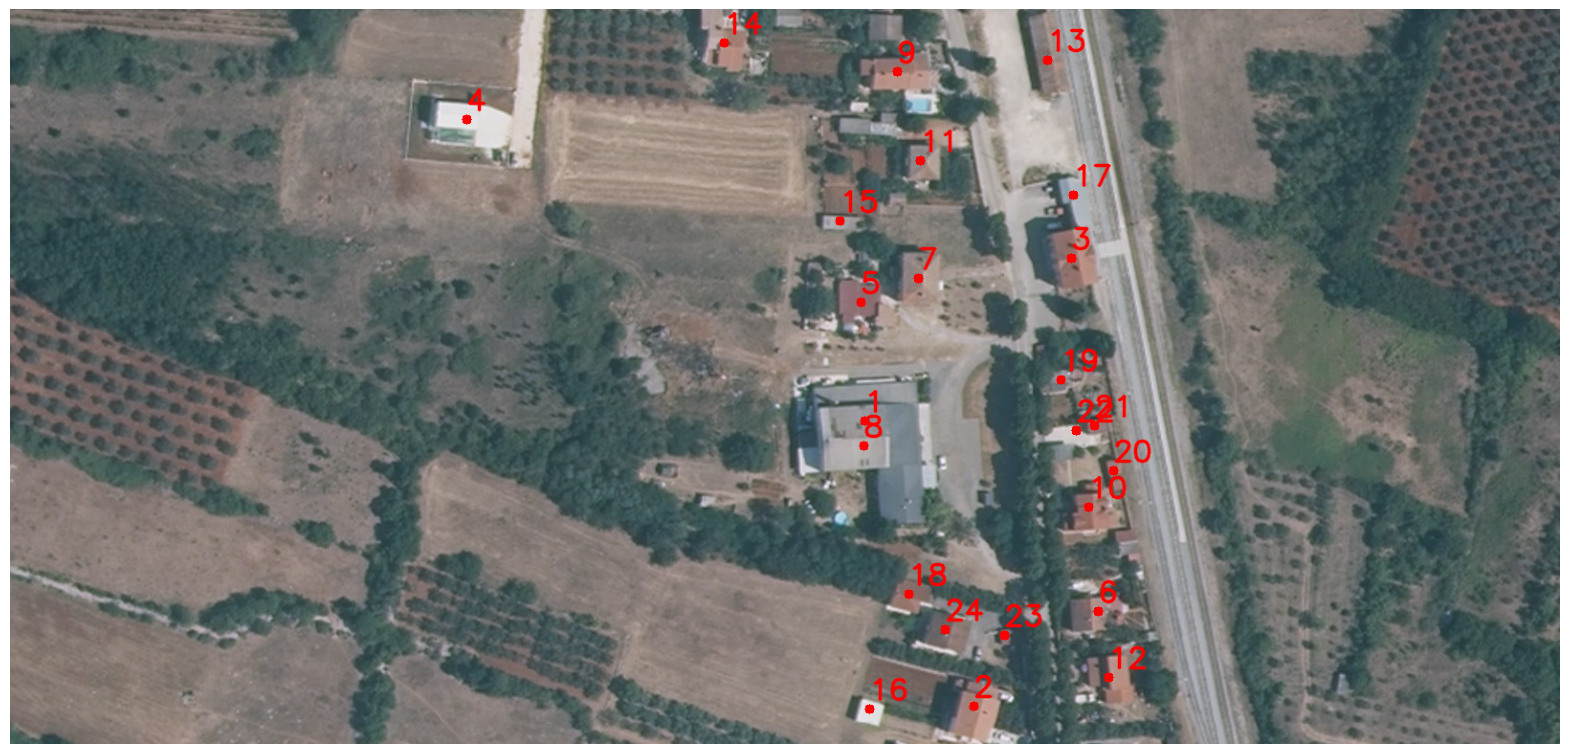

In [30]:
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import json
import numpy as np

model = YOLO(os.path.join("models", "satelliteguard-v8.pt"))

with open("coordinates.json", "r") as f:
    coords_dict = json.load(f)

image_name = "slika_1.png"
image_path = os.path.join("sample_images", image_name)

top_left = coords_dict[image_name]["top-left"]
bottom_right = coords_dict[image_name]["bottom-right"]

Tx, Ty = top_left
Bx, By = bottom_right

print("Koordinate slike:")
print(f"Tx = {Tx}, Ty = {Ty}")
print(f"Bx = {Bx}, By = {By}")

pil_img = Image.open(image_path)
img_width, img_height = pil_img.size

# Convert to a NumPy BGR image for OpenCV drawing
predicted_image_bgr = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

results = model(image_path, conf=0.4)

house_index = 1

for result in results:
    boxes = result.boxes.data
    for box in boxes:
        x1, y1, x2, y2, confidence, class_id = box.tolist()

        # Calculate center of the bounding box
        center_x_pix = (x1 + x2) / 2.0
        center_y_pix = (y1 + y2) / 2.0

        # Convert pixel coordinates to map coordinates (HTRS96/TM)
        center_x_map = Tx + (center_x_pix / img_width)  * (Bx - Tx)
        center_y_map = Ty + (center_y_pix / img_height) * (By - Ty)

        # Draw dot
        cv2.circle(
            predicted_image_bgr,
            (int(center_x_pix), int(center_y_pix)),
            radius=5,
            color=(0, 0, 255),  # Red
            thickness=-1
        )

        # Draw house number
        cv2.putText(
            predicted_image_bgr,
            str(house_index),
            (int(center_x_pix), int(center_y_pix) - 10), # slightly above the dot
            cv2.FONT_HERSHEY_SIMPLEX,
            1.0, # font scale
            (0, 0, 255), # text color (Red)
            2, # line thickness
            cv2.LINE_AA
        )

        print(f"Koordinate objekta #{house_index}: ({center_x_map:.2f}, {center_y_map:.2f})")
        # print(f"Lokacija u pikselima = ({center_x_pix:.2f}, {center_y_pix:.2f})")

        house_index += 1

# Convert back to RGB for display
predicted_image_rgb = cv2.cvtColor(predicted_image_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 10))
plt.imshow(predicted_image_rgb)
plt.axis('off')
plt.show()

## Detekcija deponija otpada

In [64]:
import json
from PIL import Image, ImageDraw, ImageFont

def parse_json(json_output):
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """
    img = im
    width, height = img.size
    draw = ImageDraw.Draw(img)

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    for bounding_box in json.loads(bounding_boxes):
      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
      abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
      abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
      abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline="red", width=4
      )

      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill="red", font=ImageFont.load_default())

In [61]:
import os
from google import genai
from google.genai import types
from dotenv import load_dotenv
from io import BytesIO

load_dotenv()

def detect_garbage(image_path):
    # Load and resize image
    im = Image.open(BytesIO(open(image_path, "rb").read()))
    im.thumbnail([1024,1024], Image.Resampling.LANCZOS)

    client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])

    bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 1 object.
    If there is no object, return an empty array.
    """

    PROMPT = "Detect the 2d bounding boxes of garbage"

    response = client.models.generate_content(
        model="gemini-2.0-flash",
        config=types.GenerateContentConfig(
            system_instruction= bounding_box_system_instructions,
            temperature=0.2,
        ),
        contents=[PROMPT, im])

    print(response.text)

    plot_bounding_boxes(im, response.text)
    return im

```json
[
  {"box_2d": [649, 601, 717, 682], "label": "garbage"}
]
```


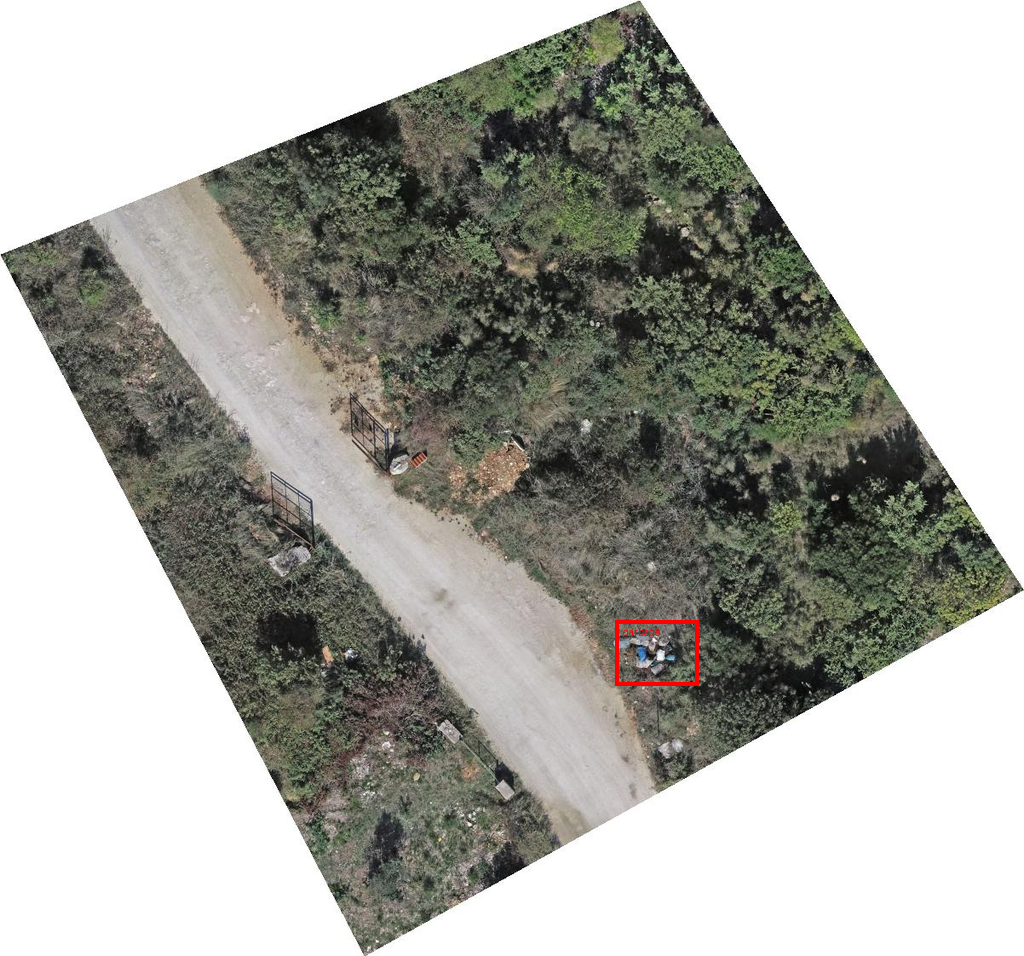

In [65]:
detect_garbage("sample_images/vodnjan_kamenolom.jpg")

[]


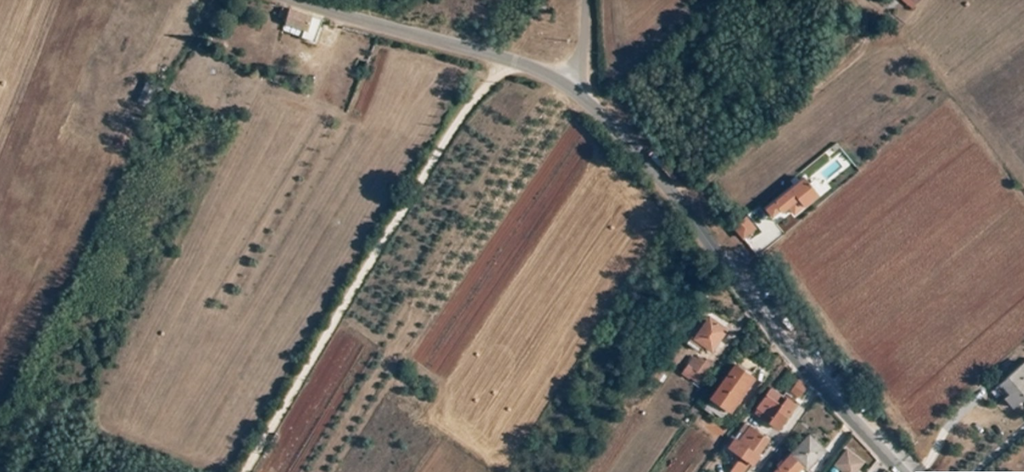

In [66]:
detect_garbage("sample_images/1.png")